In [237]:
# !pip install numpy
# !pip install matplotlib
# Basic setup: imports and define helper functions
import asyncio, asyncssh, sys, time
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

ssh_connections = {}
%store -r

async def start_connection(hostname):
    if hostname not in ssh_connections:
        ssh_connections[hostname] = await asyncssh.connect(hostname, known_hosts=None)
    return ssh_connections[hostname]

async def run_command(hostname, command):
    conn = await start_connection(hostname)
    return (await conn.create_process(command))

async def run_command_sync(hostname, command):
    conn = await start_connection(hostname)
    result = await conn.run(command)
    return result.stdout

async def run_server(hostname):
    return (await run_command(hostname, '/mydata/localuser/frida/server/server'))

async def run_client_throughput(hostname, device_id, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = '/mydata/localuser/frida/experiments/throughput_bench/client {} {} {} {} {}'.format(device_id, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
async def run_multiple_clients_throughput(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = 'cd /mydata/localuser/frida/experiments/throughput_bench && bash ./run_clients_local.sh {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))

async def run_multiple_clients_latency(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", throughput = 80, asyncOn = True):
    command_str = 'cd /mydata/localuser/frida/experiments/latency_bench && bash ./run_clients_local.sh {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
    
async def clear_server_storage(hostname):
    await run_command_sync(hostname, "rm -r ~/storage")

async def kill_server(hostname):
    await run_command_sync(hostname, "pkill server")
    

async def kill_clients(num_nodes):
    for i in range(1, num_nodes + 1):
        await run_command_sync("node{}".format(i), "pkill client")
        
async def remove_results(num_nodes):
    for i in range(1, num_nodes + 1):
        await run_command_sync("node{}".format(i), "rm -r /exp_results")
    
def parse_throughput(tstr):
    return float(tstr.split(",")[1])

# def parse_latency(tstr):
#     res = tstr.split(",")
# #     print(res)
#     return float(res[1]), float(res[2]), float(res[3])

# Kill everything
async def cleanup(num_nodes):
    await kill_clients(num_nodes)
    await kill_server("node0")
    await clear_server_storage("node0")
    await remove_results(num_nodes)


def co_sort(arr1, arr2, on="first"):
    combined = [(arr1[i], arr2[i]) for i in range(len(arr1))]
    combined.sort(key=(lambda x:x[0]) if on=="first" else (lambda x:x[1]))
    return [e[0] for e in combined],[e[1] for e in combined]

def write_to_file(filename, data):
    with open(filename, "a") as f:
        if type(data) == str:
            f.write(data)
        elif type(data) == list:
            for e in data:
                f.write("{}\n".format(e))

In [123]:
await kill_clients(10)
server_task = await run_server("node0")

In [117]:
th, avg, p50,p90,p99 = await run_latency_exp(4, 10,2, 0,[20]*20)

#N=4, #C=80, Throughput = 6093.166666666667, Avg = 18.17455280505484ms, 50th = 14.225ms, 90th = 26.181, 99th = 50.861
#N=4, #C=80, Throughput = 6899.333333333333, Avg = 16.244268939027926ms, 50th = 13.321ms, 90th = 25.88, 99th = 29.3
#N=4, #C=80, Throughput = 15393.666666666666, Avg = 6.748626567202963ms, 50th = 5.775ms, 90th = 10.475, 99th = 18.447
#N=4, #C=80, Throughput = 15488.333333333334, Avg = 6.708940977079522ms, 50th = 5.718ms, 90th = 10.298, 99th = 17.828
#N=4, #C=80, Throughput = 14621.166666666666, Avg = 7.265768862493873ms, 50th = 6.361ms, 90th = 11.137, 99th = 22.003
#N=4, #C=80, Throughput = 14961.666666666666, Avg = 6.957502350451152ms, 50th = 5.733ms, 90th = 10.681, 99th = 21.6
#N=4, #C=80, Throughput = 15155.166666666666, Avg = 6.827062651900892ms, 50th = 5.685ms, 90th = 10.491, 99th = 19.847
#N=4, #C=80, Throughput = 14723.666666666666, Avg = 7.145646385637636ms, 50th = 5.895ms, 90th = 10.835, 99th = 22.092
#N=4, #C=80, Throughput = 15040.333333333334, Avg = 6.879344

In [ ]:
# no storage cleanup
th, avg, p50,p90,p99 = await run_latency_exp(4, 10,2, 0,[20,20,20]+[1]*20)

In [112]:
th, avg, p50,p90,p99 = await run_latency_exp(4, 10,2, 0,30,50,2)

#N=4, #C=120, Throughput = 9078.166666666666, Avg = 17.972680258495657ms, 50th = 14.056ms, 90th = 26.539, 99th = 44.282
#N=4, #C=128, Throughput = 15674.0, Avg = 10.421325943175534ms, 50th = 8.817ms, 90th = 18.318, 99th = 27.331
#N=4, #C=136, Throughput = 18903.0, Avg = 8.80869730554233ms, 50th = 7.139ms, 90th = 14.514, 99th = 23.802
#N=4, #C=144, Throughput = 18824.666666666668, Avg = 9.54023208910295ms, 50th = 8.138ms, 90th = 16.87, 99th = 27.668
#N=4, #C=152, Throughput = 19379.0, Avg = 9.474873462682973ms, 50th = 7.618ms, 90th = 15.882, 99th = 26.395
#N=4, #C=160, Throughput = 19432.666666666668, Avg = 10.05520693677313ms, 50th = 8.23ms, 90th = 17.63, 99th = 28.536
#N=4, #C=168, Throughput = 19493.5, Avg = 10.321423235095459ms, 50th = 8.334ms, 90th = 17.601, 99th = 28.621
#N=4, #C=176, Throughput = 19074.166666666668, Avg = 11.150451360915724ms, 50th = 8.898ms, 90th = 19.763, 99th = 34.6
#N=4, #C=184, Throughput = 19230.0, Avg = 11.403019821459525ms, 50th = 9.238ms, 90th = 19.932, 

In [111]:
th, avg, p50,p90,p99 = await run_latency_exp(4, 10,2, 0,30,50,5)

#N=4, #C=120, Throughput = 9347.666666666666, Avg = 17.511908051920265ms, 50th = 13.943ms, 90th = 26.41, 99th = 30.389
#N=4, #C=140, Throughput = 16315.666666666666, Avg = 10.937168130835392ms, 50th = 9.245ms, 90th = 20.436, 99th = 29.773
#N=4, #C=160, Throughput = 19930.0, Avg = 9.772650577019569ms, 50th = 8.008ms, 90th = 16.516, 99th = 26.186
#N=4, #C=180, Throughput = 19716.0, Avg = 10.9917257810915ms, 50th = 9.075ms, 90th = 19.189, 99th = 31.042
#N=4, #C=200, Throughput = 20315.833333333332, Avg = 11.699258328889618ms, 50th = 9.479ms, 90th = 19.867, 99th = 30.992


In [110]:
th, avg, p50,p90,p99 = await run_latency_exp(4, 10,2, 0,20,60,4)

#N=4, #C=80, Throughput = 5921.833333333333, Avg = 18.581571388365088ms, 50th = 14.247ms, 90th = 26.047, 99th = 51.451
#N=4, #C=96, Throughput = 7233.333333333333, Avg = 18.449314308755763ms, 50th = 13.943ms, 90th = 26.168, 99th = 51.919
#N=4, #C=112, Throughput = 17359.333333333332, Avg = 8.141642132954415ms, 50th = 6.737ms, 90th = 13.146, 99th = 24.106
#N=4, #C=128, Throughput = 18364.166666666668, Avg = 8.670761637246448ms, 50th = 7.079ms, 90th = 14.314, 99th = 24.474
#N=4, #C=144, Throughput = 18666.833333333332, Avg = 9.531456567352077ms, 50th = 7.598ms, 90th = 16.246, 99th = 30.462
#N=4, #C=160, Throughput = 19220.666666666668, Avg = 10.148104470882037ms, 50th = 8.216ms, 90th = 17.661, 99th = 30.927
#N=4, #C=176, Throughput = 19503.333333333332, Avg = 10.89561578362673ms, 50th = 8.789ms, 90th = 18.854, 99th = 32.595
#N=4, #C=192, Throughput = 19801.333333333332, Avg = 11.505736137297152ms, 50th = 9.268ms, 90th = 19.927, 99th = 32.198
#N=4, #C=208, Throughput = 19674.833333333332,

In [78]:
async def run_throughput_exp(num_nodes = 2, duration = 20, keepout = 5, data_size = 0, min_cpn = 20, max_cpn = 100, step_size = 5, warmup_period = 5, server_node = "node0"):
    max_clients = max_cpn * num_nodes
    throughputs = [0]
    num_clients_record = [0]
    

    for num_clients_per_node in range(min_cpn, max_cpn + 1, step_size):
        await cleanup(num_nodes)
        time.sleep(10)
        server_task = await run_server(server_node)
        time.sleep(warmup_period)
        ctasks = []
        num_clients = num_nodes * num_clients_per_node
        for node in range(1, num_nodes + 1):
            ctask = await run_multiple_clients_throughput(num_clients_per_node, "node{}".format(node), "exp_C{}_node{}_{}".format(num_clients, node, randrange(1000000)), duration, keepout, data_size, "http://node0:8080")
            ctasks.append(ctask)
        local_throughputs = []
        time.sleep(duration + warmup_period)
        
        curr_node = 0
        for ctask in ctasks:
            curr_node += 1
            coutput = await ctask.stdout.read()
            cerror = await ctask.stderr.read()
            if str(cerror) != "":
                print("Node {}: ".format(curr_node) + str(cerror))
            for line in coutput.split("\n")[:-1]:
                if line != "":
                    local_throughputs.append(parse_throughput(line))
            ctask.terminate()
        num_clients_record.append(num_clients)

        throughput = sum(local_throughputs)
        print("#Nodes={}, #Clients={}, Throughput = {}/s".format(num_nodes, num_clients, throughput))
        throughputs.append(throughput)

    server_task.terminate()
    await clear_server_storage(server_node)
    return num_clients_record, throughputs

In [227]:
async def run_latency_exp_single(num_nodes = 10, duration = 20, keepout = 5, data_size = 0,num_clients = 100, server_node = "node0", is_warmup = False):
#     num_clients = num_nodes * num_clients_per_node
    time.sleep(5)
    ctasks = []
    
    for node in range(1, num_nodes + 1):
        num_clients_this_node = (num_clients // num_nodes + (1 if node < (num_clients % num_nodes) else 0))
        ctask = await run_multiple_clients_latency(num_clients_this_node, "node{}".format(node), "exp_C{}_node{}_{}".format(num_clients, node, randrange(1000000)), duration, keepout, data_size, "http://node0:8080")
        ctasks.append(ctask)
        
    time.sleep(duration)
    curr_node = 0
    
    all_latencies = []
    for ctask in ctasks:
        curr_node += 1
        coutput = await ctask.stdout.read()
        cerror = await ctask.stderr.read()
        if str(cerror) != "":
            print("Node {}: \n".format(curr_node) + str(cerror))
        if not is_warmup:
            for line in coutput.split("\n")[:-1]:
                if line != "":
                    lat = float(line)
                    all_latencies.append(lat)
        ctask.terminate()
    if not is_warmup:
        nmesg = len(all_latencies)
        throughput = float(nmesg) / (duration - 2* keepout)
        average_lat = sum(all_latencies) / nmesg / 1000.0

        all_latencies.sort()
        p50_lat = all_latencies[nmesg // 2] / 1000.0
        p90_lat = all_latencies[int(nmesg * 0.9)] / 1000.0
        p99_lat = all_latencies[int(nmesg * 0.99)] / 1000.0
        return throughput, average_lat, p50_lat, p90_lat, p99_lat
    else:
        return None, None, None, None, None
    
#     print("#N={}, #C={}, Throughput = {}, Avg = {}ms, 50th = {}ms, 90th = {}, 99th = {}".format(num_nodes, num_clients, throughput, average_lat, p50_lat, p90_lat, p99_lat))


async def run_latency_exp(num_nodes = 10, duration = 20, keepout = 5, data_size = 0, num_list = [1], warmup_runs = 3, repeat = 5, server_node = "node0"):
#     if max_cpn is None:
#         max_cpn = min_cpn
    throughputs = []
    avgs = []
    p50s = []
    p90s = []
    p99s = []
    print("Clearing up server and clients...")
    await cleanup(num_nodes)
    time.sleep(5)
    server_task = await run_server(server_node)
    time.sleep(5)
    print("{} warm-ups running...".format(warmup_runs))
    for i in range(warmup_runs):
        await run_latency_exp_single(num_nodes, 20, 1, num_clients = 200, server_node=server_node, is_warmup=True)
    print("Starting benchmark...")
    for num_clients in num_list:
        sample_throughputs = []
        sample_avgs = []
        sample_p50s = []
        sample_p90s = []
        sample_p99s = []
        for trial in range(repeat):
            throughput, avg, p50, p90, p99 = await run_latency_exp_single(num_nodes, duration, keepout, data_size, num_clients, server_node)
            sample_throughputs.append(throughput)
            sample_avgs.append(avg)
            sample_p50s.append(p50)
            sample_p90s.append(p90)
            sample_p99s.append(p99)
        print("#N={}, #C={},T = {}, Avgs = {}".format(num_nodes, num_clients, sample_throughputs, sample_avgs))
        mean_throughput = sum(sample_throughputs) / repeat
        mean_avg = sum(sample_avgs) / repeat
        mean_p50 = sum(sample_p50s) / repeat
        mean_p90 = sum(sample_p90s) / repeat
        mean_p99 = sum(sample_p99s) / repeat
        
        print("#N={}, #C={}, Throughput = {:.2f}, Avg = {:.2f}ms, 50th = {:.2f}ms, 90th = {:.2f}ms, 99th = {:.2f}ms".format(num_nodes, num_clients, mean_throughput, mean_avg, mean_p50, mean_p90, mean_p99))
        throughputs.append(mean_throughput)
        avgs.append(mean_avg)
        p50s.append(mean_p50)
        p90s.append(mean_p90)
        p99s.append(mean_p99)
    return throughputs, avgs, p50s, p90s, p99s



In [222]:
num_nodes = 10
duration = 30
keepout = 5
data_size = 0
num_list = list(range(4,201,4))
warmup_runs = 3
repeat = 5
server_node = "node0"

throughputs = []
avgs = []
p50s = []
p90s = []
p99s = []
print("Clearing up server and clients...")
await cleanup(num_nodes)
time.sleep(5)
server_task = await run_server(server_node)
time.sleep(5)
print("{} warm-ups running...".format(warmup_runs))
for i in range(warmup_runs):
    await run_latency_exp_single(num_nodes, 20, 1, num_clients = 200, server_node=server_node, is_warmup=True)
print("Starting benchmark...")
for num_clients in num_list:
    sample_throughputs = []
    sample_avgs = []
    sample_p50s = []
    sample_p90s = []
    sample_p99s = []
    for trial in range(repeat):
        throughput, avg, p50, p90, p99 = await run_latency_exp_single(num_nodes, duration, keepout, data_size, num_clients, server_node)
        sample_throughputs.append(throughput)
        sample_avgs.append(avg)
        sample_p50s.append(p50)
        sample_p90s.append(p90)
        sample_p99s.append(p99)
    print("#N={}, #C={},T = {}, Avgs = {}".format(num_nodes, num_clients, sample_throughputs, sample_avgs))
    mean_throughput = sum(sample_throughputs) / repeat
    mean_avg = sum(sample_avgs) / repeat
    mean_p50 = sum(sample_p50s) / repeat
    mean_p90 = sum(sample_p90s) / repeat
    mean_p99 = sum(sample_p99s) / repeat
        
    print("#N={}, #C={}, Throughput = {:.2f}, Avg = {:.2f}ms, 50th = {:.2f}ms, 90th = {:.2f}ms, 99th = {:.2f}ms".format(num_nodes, num_clients, mean_throughput, mean_avg, mean_p50, mean_p90, mean_p99))
    throughputs.append(mean_throughput)
    avgs.append(mean_avg)
    p50s.append(mean_p50)
    p90s.append(mean_p90)
    p99s.append(mean_p99)

Clearing up server and clients...
3 warm-ups running...
Starting benchmark...
#N=10, #C=4,T = [688.8, 688.2, 690.9, 687.65, 695.4], Avgs = [5.29870550232288, 5.296361086893345, 5.301501302648719, 5.301596597106086, 5.243561331607708]
#N=10, #C=4, Throughput = 690.19, Avg = 5.29ms, 50th = 4.43ms, 90th = 8.41ms, 99th = 9.06ms
#N=10, #C=8,T = [1606.25, 1590.25, 1590.15, 1605.15, 1601.5], Avgs = [6.622267175097276, 6.60914636063512, 6.779612646605666, 6.5451736597825745, 6.5954860443334375]
#N=10, #C=8, Throughput = 1598.66, Avg = 6.63ms, 50th = 8.27ms, 90th = 8.52ms, 99th = 12.01ms
#N=10, #C=12,T = [2488.2, 2487.85, 2493.65, 2490.5, 2487.35], Avgs = [6.8039226951209715, 6.844736358703297, 6.656671044452911, 6.760073178076692, 6.5817485275494]
#N=10, #C=12, Throughput = 2489.51, Avg = 6.73ms, 50th = 8.27ms, 90th = 8.54ms, 99th = 12.67ms
#N=10, #C=16,T = [3378.65, 3362.65, 3354.95, 3361.15, 3371.4], Avgs = [6.887972844183327, 6.880136841479191, 6.861767328872263, 6.9179631376165895, 6.86823

In [223]:
throughputs_finer = throughputs
avgs_finer = avgs
p50s_finer=p50s
p90s_finer=p90s
p99s_finer=p99s
    
%store throughputs_finer
%store avgs_finer

%store p50s_finer
%store p90s_finer
%store p99s_finer

Stored 'throughputs_finer' (list)
Stored 'avgs_finer' (list)
Stored 'p50s_finer' (list)
Stored 'p90s_finer' (list)
Stored 'p99s_finer' (list)


In [242]:
write_to_file("throughputs_finer", throughputs_finer)
write_to_file("avgs_finer", avgs_finer)
write_to_file("p50s_finer", p50s_finer)
write_to_file("p90s_finer", p90s_finer)
write_to_file("p99s_finer", p99s_finer)

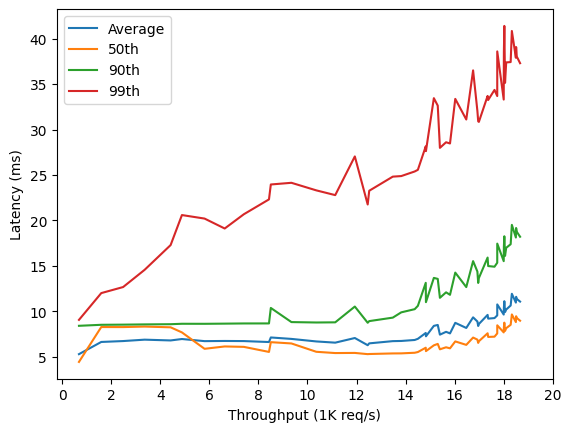

In [228]:
throughputs_sorted, avgs_sorted = co_sort(throughputs_finer, avgs_finer)
throughputs_sorted, p50s_sorted = co_sort(throughputs_finer, p50s_finer)
throughputs_sorted, p90s_sorted = co_sort(throughputs_finer, p90s_finer)
throughputs_sorted, p99s_sorted = co_sort(throughputs_finer, p99s_finer)
plt.plot(np.array(throughputs_sorted)/1000.0, avgs_sorted, label="Average")
plt.plot(np.array(throughputs_sorted)/1000.0, p50s_sorted, label="50th")
plt.plot(np.array(throughputs_sorted)/1000.0, p90s_sorted, label="90th")
plt.plot(np.array(throughputs_sorted)/1000.0, p99s_sorted, label="99th")
plt.xticks(np.arange(0, 22, step = 2))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [207]:
throughputs_real = throughputs
avgs_real = avgs
p50s_real=p50s
p90s_real=p90s
p99s_real=p99s
    
%store throughputs_real
%store avgs_real
%store p50s_real
%store p90s_real
%store p99s_real

Stored 'throughputs_real' (list)
Stored 'avgs_real' (list)
Stored 'p50s_real' (list)
Stored 'p90s_real' (list)
Stored 'p99s_real' (list)


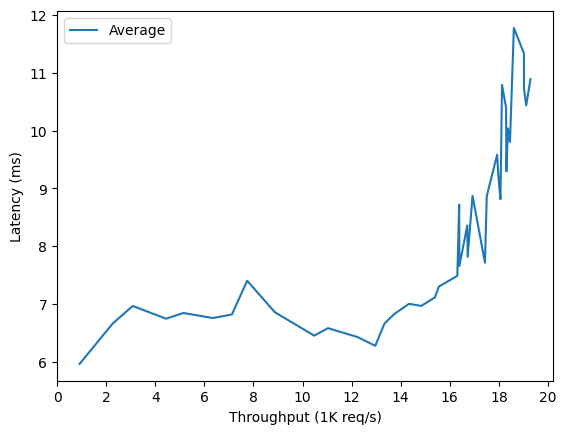

In [219]:
throughputs_sorted, avgs_sorted = co_sort(throughputs_real, avgs_real)
throughputs_sorted, p50s_sorted = co_sort(throughputs_real, p50s_real)
throughputs_sorted, p90s_sorted = co_sort(throughputs_real, p90s_real)
throughputs_sorted, p99s_sorted = co_sort(throughputs_real, p99s_real)
plt.plot(np.array(throughputs_sorted)/1000.0, avgs_sorted, label="Average")
# plt.plot(np.array(throughputs_sorted)/1000.0, p50s_sorted, label="50th")
# plt.plot(np.array(throughputs_sorted)/1000.0, p90s_sorted, label="90th")
# plt.plot(np.array(throughputs_sorted)/1000.0, p99s_sorted, label="99th")
plt.xticks(np.arange(0, 22, step = 2))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [241]:
write_to_file("throughputs_real", throughputs_real)
write_to_file("avgs_real", avgs_real)
write_to_file("p50s_real", p50s_real)
write_to_file("p90s_real", p90s_real)
write_to_file("p99s_real", p99s_real)

In [151]:
throughputs_test, avgs_test, p50s_test, p90s_test, p99s_test = await run_latency_exp(num_nodes = 10, duration = 30, keepout = 5, repeat=3, num_list=list(range(3,31,3)))
%store throughputs_test
%store avgs_test
%store p50s_test
%store p90s_test
%store p99s_test

Clearing up server and clients...
3 warm-ups running...
Starting benchmark...
#N=10, #C=30,T = [6553.2, 6555.85, 6636.45], Avgs = [6.656949902337789, 6.533140546229704, 6.499770148196702]
#N=10, #C=30, Throughput = 6581.833333333333, Avg = 6.563286865588065ms, 50th = 5.660666666666667ms, 90th = 8.620666666666667, 99th = 17.375333333333334
#N=10, #C=60,T = [12230.3, 11998.35, 11965.35], Avgs = [6.332923346115795, 6.439828359732797, 6.457574471285838]
#N=10, #C=60, Throughput = 12064.666666666666, Avg = 6.410108725711477ms, 50th = 5.324666666666666ms, 90th = 8.955, 99th = 21.798333333333332
#N=10, #C=90,T = [14807.0, 14554.6, 14481.15], Avgs = [7.244521648544607, 7.367480129993267, 7.389174792747814]
#N=10, #C=90, Throughput = 14614.25, Avg = 7.3337255237618955ms, 50th = 5.783333333333334ms, 90th = 11.835999999999999, 99th = 24.44633333333333
#N=10, #C=120,T = [17881.3, 17987.0, 17249.5], Avgs = [7.843479098275853, 7.8277245371657305, 8.140241951940636]
#N=10, #C=120, Throughput = 17705.

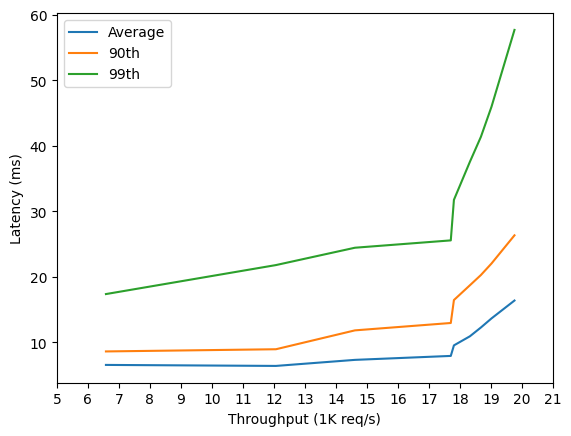

In [176]:
throughputs_sorted, avgs_sorted = co_sort(throughputs_test, avgs_test)
throughputs_sorted, p50s_sorted = co_sort(throughputs_test, p50s_test)
throughputs_sorted, p90s_sorted = co_sort(throughputs_test, p90s_test)
throughputs_sorted, p99s_sorted = co_sort(throughputs_test, p99s_test)
plt.plot(np.array(throughputs_sorted[:-1])/1000.0, avgs_sorted[:-1], label="Average")
# plt.plot(np.array(throughputs_sorted[:-1])/1000.0, p50s_sorted[:-1], label="50th")
plt.plot(np.array(throughputs_sorted[:-1])/1000.0, p90s_sorted[:-1], label="90th")
plt.plot(np.array(throughputs_sorted[:-1])/1000.0, p99s_sorted[:-1], label="99th")
plt.xticks(np.arange(5, 22, step = 1))
# plt.yticks(np.arange(5, 22, step = 1))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [ ]:
throughputs_N10C20_nagle, latencies_N10C20_nagle = await run_latency_exp(num_nodes=10, duration = 30, keepout = 5, num_clients_per_node=20, min_tpc = 10, max_tpc = 150, step_size = 10,warmup_period = 3)
%store throughputs_N10C20_nagle
%store latencies_N10C20_nagle

In [ ]:
throughputs_N10C20, latencies_N10C20 = await run_latency_exp(num_nodes=10, duration = 30, keepout = 5, num_clients_per_node=20, min_tpc = 20, max_tpc = 150, step_size = 10,warmup_period = 3)
%store throughputs_N10C20
%store latencies_N10C20

In [ ]:
throughputs_N4C50, latencies_N4C50 = await run_latency_exp(num_nodes=4, duration = 70, keepout = 5, num_clients_per_node=50, min_tpc = 50, max_tpc = 120, step_size = 1,warmup_period = 5)
%store throughputs_N4C50
%store latencies_N4C50

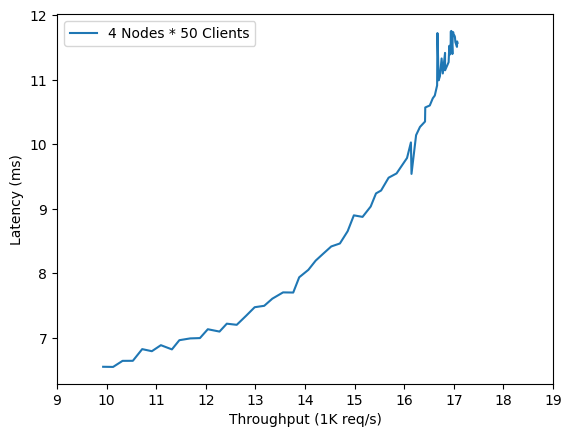

In [33]:
throughputs_sorted, latencies_sorted = co_sort(throughputs_N4C50, latencies_N4C50)
plt.plot(np.array(throughputs_sorted)/1000, latencies_sorted, label="4 Nodes * 50 Clients")
# plt.plot(num_clients, throughputs, label="22")
plt.xticks(np.arange(9, 20, step = 1))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [240]:
write_to_file("throughputs_N4C50", throughputs_N4C50)
write_to_file("latencies_N4C50", latencies_N4C50)

In [ ]:
throughputs_N4C25, latencies_N4C25 = await run_latency_exp(num_nodes=4, duration = 30, keepout = 5, num_clients_per_node=25, min_tpc = 80, max_tpc = 200, step_size = 10,warmup_period = 3)
%store throughputs_N4C25
%store latencies_N4C25

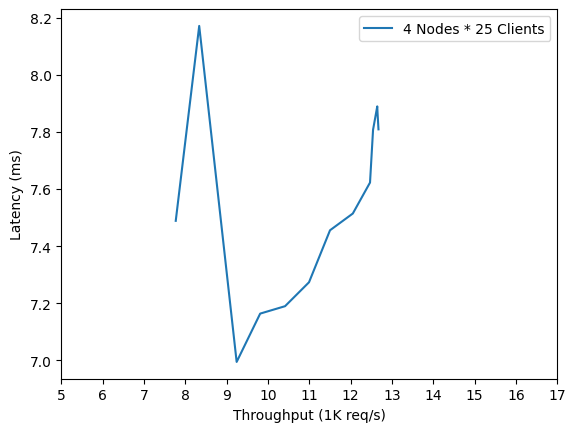

In [32]:
throughputs_sorted, latencies_sorted = co_sort(throughputs_N4C25, latencies_N4C25)
plt.plot(np.array(throughputs_sorted)/1000, latencies_sorted, label="4 Nodes * 25 Clients")
# plt.plot(num_clients, throughputs, label="22")
plt.xticks(np.arange(5, 18, step = 1))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [ ]:
num_clients_n1, throughputs_n1 = await run_throughput_exp(num_nodes = 1, min_cpn = 8, max_cpn = 200, step_size=8)
%store num_clients_n1
%store throughputs_n1

num_clients_n2, throughputs_n2 = await run_throughput_exp(num_nodes = 2, min_cpn = 4, max_cpn = 100, step_size=4)
%store num_clients_n2
%store throughputs_n2

num_clients_n4, throughputs_n4 = await run_throughput_exp(num_nodes = 4, min_cpn = 2, max_cpn = 50, step_size=2)
%store num_clients_n4
%store throughputs_n4

num_clients_n8, throughputs_n8 = await run_throughput_exp(num_nodes = 8, min_cpn = 1, max_cpn = 25, step_size=1)
%store num_clients_n8
%store throughputs_n8

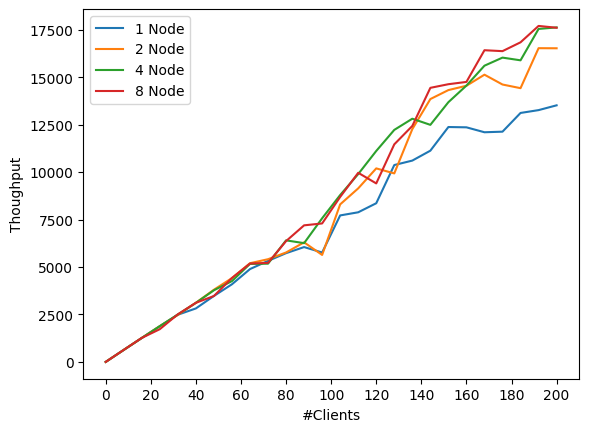

In [31]:
plt.plot(num_clients_n1, throughputs_n1, label="1 Node")
plt.plot(num_clients_n2, throughputs_n2, label="2 Node")
plt.plot(num_clients_n4, throughputs_n4, label="4 Node")
plt.plot(num_clients_n8, throughputs_n8, label="8 Node")
plt.xticks(np.arange(0, 201, step = 20))
plt.xlabel("#Clients")
plt.ylabel("Thoughput")
plt.legend()
plt.show()

In [239]:
write_to_file("num_clients_n1", num_clients_n1)
write_to_file("throughputs_n1", throughputs_n1)
write_to_file("num_clients_n2", num_clients_n2)
write_to_file("throughputs_n2", throughputs_n2)
write_to_file("num_clients_n4", num_clients_n4)
write_to_file("throughputs_n4", throughputs_n4)
write_to_file("num_clients_n8", num_clients_n8)
write_to_file("throughputs_n8", throughputs_n8)

In [ ]:
num_clients_n4_fine, throughputs_n4_fine = await run_throughput_exp(num_nodes = 4, duration = 70, keepout = 5, min_cpn = 2, max_cpn = 75, step_size=1)
%store num_clients_n4_fine
%store throughputs_n4_fine

In [ ]:
num_clients_n4_fine_more, throughputs_n4_fine_more = await run_throughput_exp(num_nodes = 4, duration = 70, keepout = 5, min_cpn = 76, max_cpn = 100, step_size=1)
%store num_clients_n4_fine_more
%store throughputs_n4_fine_more

In [ ]:
num_clients_n4_fine_final = num_clients_n4_fine + num_clients_n4_fine_more[1:]
throughputs_n4_fine_final = throughputs_n4_fine + throughputs_n4_fine_more[1:]
%store num_clients_n4_fine_final
%store throughputs_n4_fine_final

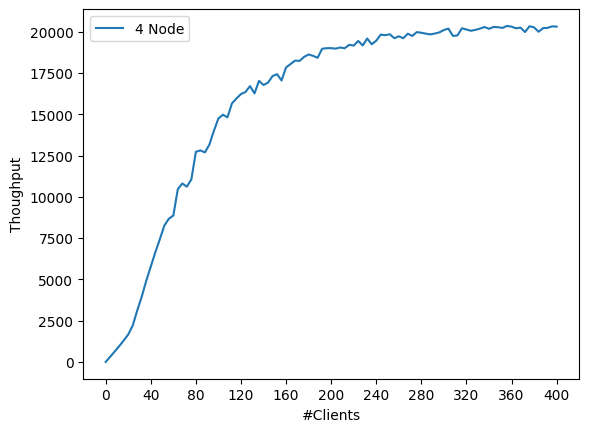

In [30]:
plt.plot(num_clients_n4_fine_final, throughputs_n4_fine_final, label="4 Node")
plt.xticks(np.arange(0, 401, step = 40))
plt.xlabel("#Clients")
plt.ylabel("Thoughput")
plt.legend()
plt.show()

In [238]:
write_to_file("num_clients_n4_fine_final", num_clients_n4_fine_final)
write_to_file("throughputs_n4_fine_final", throughputs_n4_fine_final)